<a href="https://colab.research.google.com/github/kaspar0852/GAN-architecture/blob/main/discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
#we are going to create a function to display grid of generated images vs real images
#so we are going to need a way to visualize this grid


In [ ]:
#visualization function
#here ch is taken 1 because for black and white images ch is 1 
#then the size of the data set has images of size 28 by 28
#then the num =16 is the number of grid we want to show 
#detach function is going to detach the variable from computation of the graident
def show(tensor, ch=1,size=(28,28),num=16):
  #tensor which arrives in this fxn will come as :128*784 because we are processing 128 images at a time 
  data = tensor.detach().cpu().view(-1,ch,*size) #->128 * 1 * 28 * 28
  grid = make_grid(data[:num], nrow = 4).permute(1,2,0) 
  plt.imshow(grid)
  plt.show()

In [ ]:
#Setup of the main parameters and hyperparameters
epochs = 500 
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_dis_loss = 0 

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.',download = True, transform=transforms.ToTensor()),shuffle = True,batch_size = bs)


In [ ]:
#declare our models

#Generator

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      #A nn with linear layers only cannot learn complex tasks 
      #so we should introduce some non linearity,
      #and one of the non linear function is ReLU function
      nn.ReLU(inplace = True)
  )

class Generator(nn.Module):
  #The generator will output an image the dimensio of that image in this case-
  #-will be i_dim = 784 i.e 28 * 28 
  def __init__(self,z_dim = 64, i_dim = 784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), #size will enter as 64 and exit as 128
        genBlock(h_dim, h_dim*2), #size will enter as 128 and exit as 256,128 is taken from the first blocks output 
        genBlock(h_dim*2, h_dim*4),#input as 256 and output as 512
        genBlock(h_dim*4, h_dim*8),#input as 512 and output as 1024
        #now we have to think of the output 
        # so for the o/p we are going to initialize a single linear layer which will go to privious o/p i.e h_dim*8 to-
        #- to the size of whatever we want to generate which is the size of our dataset i_dim
        nn.Linear(h_dim*8, i_dim), #input as 1024 to o/p as 784 which is the size of our dataset
        #then finally we tell the generator that we want the pixels of the image to be between the-
        #-values of 0 and 1 so we use sigmoid function
        nn.Sigmoid()
    )
 
  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

#Discriminator
def disBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim = 784, h_dim = 256):
    super().__init__()
    self.disc =  nn.Sequential(
        #the first layer will go from the dimension of the image to the dimension of the hidden layer-
        #-we are going to take large value for hidden layer
        disBlock(i_dim,h_dim*4), #size of image =724 to o/p 1024
        disBlock(h_dim*4,h_dim*2), # 1024 , 512
        disBlock(h_dim*2,h_dim), # 512, 256
        #now lets think of the output
        nn.Linear(h_dim, 1) # 256,1
    )

  def forward(self,image):
    return self.disc(image)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

In [ ]:
 gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([7, 4, 7, 7, 2, 4, 8, 8, 2, 6])


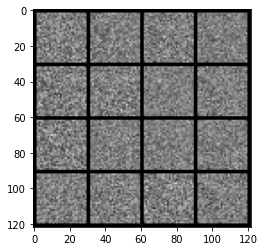

In [ ]:
#iterators 
x,y = next(iter(dataloader))
#here what we are saying is that take the data loader structure,-
#-cast it as an iterator and please give me the next batch,-
#-so the data loader is going to give us the whole batch of 128 images
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs,z_dim)
fake = gen(noise)
show(fake)

In [ ]:
#we can see that what the data loader returns is a batch of 128 images,-
#with 1 channel each beacuse it is a b/w image,28 by 28 pixels and-
#-128 labels

#what we are seeing here is the initial output of the passing the-
#-noise through the generator.Because the generator did not begin to learn,
#it produces a very noisy output

In [ ]:
#calculating the loss

#generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  #this will create a tensor with dimensionility similar to predictions and it is going to fill it with ones
  gen_loss = loss_func(pred,targets)
  #explanation of above
  #first we get the noise vectors then we pass them through the generator then we obtain fake images-
  #-we pass the fake images to the discriminator and then we comapre predictions-
  #-with the value of 1 with the help of loss function 
  return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake,disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss)/2

  return disc_loss

In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1

